## Regressão

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [2]:
df = pd.read_csv('data.csv')

In [3]:
drop_cols = df.columns[22:48]
df = df.drop(drop_cols, axis = 1)
df = df.drop(['Unnamed: 0','ID','Jersey Number','Joined','Special',
               'Weight','Height','Contract Valid Until','Wage','Value','Name','Club',
               'Preferred Foot', 'Work Rate', 'Nationality'], axis = 1)
df = df.dropna()

Primeiramente, para preprocessar os dados, removemos as colunas relativas à habilidade do jogador em posições diferentes das suas principais, já que esse tipo de informação não é relevante para o cálculo do Overall. Removemos também dados nominais, como: "ID, nome, número da camisa, clube, etc". Linhas com valores nulos também foram removidas para ser possível realizar a regressão.

No nosso modelo de regressão, vamos tentar prever o Overall de um jogador usando diversos atributos. Para isso, algumas modificações foram feitas no dataset. Primeiro, por existirem mais de 20 posições no conjunto de dados, simplificamos elas em 6 grandes grupos: GK representando os goleiros, DF representando os defensores, DM os jogadores de meio defensivos, MF os meias, AM os meias ofensivos e ST representando os atacantes. Além disso, para evitar a criaçao de muitas colunas esparsas usando one-hot encoding, foi removida a coluna de nacionalidade, uma outra alternativa seria criar uma nova coluna binária em que 1 seria se a nação é grande o suficiente (escolher um número mínimo para considerar como grande) e 0, caso contrário.

Depois, por apresentar atributos em diversas escalas, normalizamos as colunas do conjunto de treino. E, antes de prever o conjunto de teste, utilizamos a média e o desvio padrão do conjunto de treino para normalizar o teste.

In [4]:
def simple_position(df):
    if (df['Position'] == 'GK'):
        return 'GK'
    elif ((df['Position'] == 'RB') | (df['Position'] == 'LB') | (df['Position'] == 'CB') | (df['Position'] == 'LCB') | (df['Position'] == 'RCB') | (df['Position'] == 'RWB') | (df['Position'] == 'LWB') ):
        return 'DF'
    elif ((df['Position'] == 'LDM') | (df['Position'] == 'CDM') | (df['Position'] == 'RDM')):
        return 'DM'
    elif ((df['Position'] == 'LM') | (df['Position'] == 'LCM') | (df['Position'] == 'CM') | (df['Position'] == 'RCM') | (df['Position'] == 'RM')):
        return 'MF'
    elif ((df['Position'] == 'LAM') | (df['Position'] == 'CAM') | (df['Position'] == 'RAM') | (df['Position'] == 'LW') | (df['Position'] == 'RW')):
        return 'AM'
    elif ((df['Position'] == 'RS') | (df['Position'] == 'ST') | (df['Position'] == 'LS') | (df['Position'] == 'CF') | (df['Position'] == 'LF') | (df['Position'] == 'RF')):
        return 'ST'
    else:
        return df.Position

In [5]:
df['Simple Position'] = df.apply(simple_position, axis=1)

df = df.drop(['Position'], axis=1)

df.head()

,Age,Overall,Potential,International Reputation,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Simple Position
0,31,94,94,5.0,4.0,4.0,84.0,95.0,70.0,90.0,...,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,ST
1,33,94,94,5.0,4.0,5.0,84.0,94.0,89.0,81.0,...,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,ST
2,26,92,93,5.0,5.0,5.0,79.0,87.0,62.0,84.0,...,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,AM
3,27,91,93,4.0,3.0,1.0,17.0,13.0,21.0,50.0,...,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,GK
4,27,91,92,4.0,5.0,4.0,93.0,82.0,55.0,92.0,...,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,MF


Para selecionar quais colunas irão entrar no modelo de regressão linear, usamos o método de ranqueamento de features recursivo, que funciona da seguinte forma: o estimador é treinado no conjunto inicial de features e a importância das features é obtida através do seu coeficiente. Então, as features menos importantes são cortadas do conjunto de features. O procedimento é repetido até que o conjunto de features seja igual ao número desejado de features. Então para encontrar o número ótimo de features, iteramos sobre o conjunto completo de features e escolhemos aquele que obteve o melhor R².

Obtivemos que o número ótimo de features é 34.  Seguem: ('Age', 'Potential', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Reactions', 'Balance', 'ShotPower', 'Stamina', 'Strength', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Simple Position_AM', 'Simple Position_DF', 'Simple Position_DM', 'Simple Position_GK', 'Simple Position_MF', 'Simple Position_ST').

In [7]:
## NAO VAMOS COLOCAR ISSO AQUI NO DO FLAVIO, COLOQUEI SO PRA CONSEGUIR TER UMA EXPLICACAO PRO LOIC DAS COLUNAS
## ESCOLHIDAS.


y = df["Overall"]

X = df.drop(["Overall"], axis=1)
X = pd.get_dummies(X)

#no of features
nof_list=np.arange(1,43)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
    model = linear_model.LinearRegression()
    
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 34
Score with 34 features: 0.931534


In [8]:
cols = list(X.columns)
model = linear_model.LinearRegression()#Initializing RFE model
rfe = RFE(model, 34)             #Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  #Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Age', 'Potential', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Reactions', 'Balance',
       'ShotPower', 'Stamina', 'Strength', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Simple Position_AM', 'Simple Position_DF', 'Simple Position_DM',
       'Simple Position_GK', 'Simple Position_MF', 'Simple Position_ST'],
      dtype='object')


In [9]:
y = df["Overall"]

X = df.drop(["Overall"], axis=1)
X = pd.get_dummies(X)

X = X[['Age', 'Potential', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Reactions', 'Balance',
       'ShotPower', 'Stamina', 'Strength', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Simple Position_AM', 'Simple Position_DF', 'Simple Position_DM',
       'Simple Position_GK', 'Simple Position_MF', 'Simple Position_ST']]

# Transformando as variaveis categoricas em binarias usando one-hot encoding
X = pd.get_dummies(X)

X = X.values
y = y.values

# dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
# Por apresentar dados em escalas muito diferentes, iremos normalizar as colunas.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_new_train = scaler.fit_transform(X_train)

In [11]:
# ajustando o modelo com o conjunto de treino
model = linear_model.LinearRegression()
model.fit(X_new_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [12]:
# usando a media e o desvio padrão do treino para converter o teste
(X_test - X_train.mean()) / X_train.std(ddof=1)

X_test_new = scaler.transform(X_test)

In [13]:
y_pred = model.predict(X_test_new)

In [14]:
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}' )
print(f'R²: {r2_score(y_test, y_pred):.2f}')

Mean squared error: 3.32
R²: 0.93


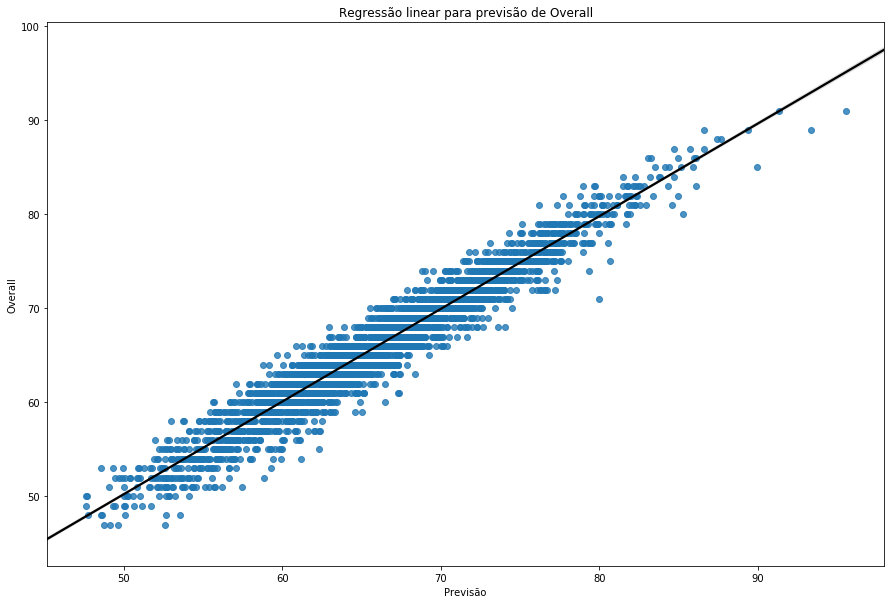

In [15]:
plt.figure(figsize=(15,10))
sns.regplot(y_pred, y_test, line_kws={'color':'black','alpha':1})
plt.xlabel("Previsão")
plt.ylabel("Overall")
plt.title("Regressão linear para previsão de Overall")
plt.show()